In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Helper functions

In [2]:
def get_exp_details(root_dir, path):
    result_details={}
    details_path = root_dir+ 'details_'+ path + '.txt'
    with open(details_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        key, val = line[:-1].split(':')
        key, val = key.strip(' '), val.strip(' ')
        if key in ['ratio', 'alpha_0']:
            val = float(val)
        if key in ['Times', 'Weights', 'Epochs', 'book_keep_freq', 'g_times', 'g_epochs','g_weight', 'freq_reduce_by', 'freq_reduce_after']:
            val = int(val)
        result_details[key] = val
    return result_details

def get_exp_results(r_det):
    root_dir = r_det['result_root_dir']
    path = r_det['result_path']
    grad_file_path = root_dir+'grad_'+path
    hess_file_path = root_dir+'hess_'+path
    gen_file_path  = root_dir+'gen_'+path
    
    # print(result_details)
    grad_list    = []
    hess_list    = []
    gen_err_list = []
    
    with open(grad_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(') ')
        # print('tensors',tensors)
        t_list = [float(t[7:].split(' ')[0][:-1]) for t in tensors]
        # print('grad_list_i length:',len(t_list))
        grad_list.append(t_list)
    
    with open(hess_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t[7:-1]) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        hess_list.append(t_list)
    
    with open(gen_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        gen_err_list.append(t_list)
        
    hess_list = np.array(hess_list)
    grad_list = np.array(grad_list)
    gen_err_list = np.array(gen_err_list)
    print('hess list shape:',hess_list.shape)
    print('grad list shape:',grad_list.shape)
    print('gen err list shape:',gen_err_list.shape)
    
    # K_g = np.max(np.mean(np.array(grad_list), 0))
    # L_g = np.max(np.mean(np.array(hess_list), 0))
    
    K_g = np.max(np.max(np.array(grad_list), 1))
    L_g = np.max(np.max(np.array(hess_list), 1))
    
    K_g_avg = np.mean(grad_list)
    L_g_avg = np.mean(hess_list)
    K_g_run_avg = []
    L_g_run_avg = []
    for i, kgi in enumerate(np.mean(grad_list, 0)):
        temp = np.mean(np.mean(grad_list, 0)[:i+1])
        K_g_run_avg.append(temp)
    for i,lgi in enumerate(np.mean(hess_list, 0)):
        temp = np.mean(np.mean(hess_list, 0)[:i+1])
        L_g_run_avg.append(temp)
        
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(20000):
        if i%book_keep_freq==0:
            x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by
    
    return grad_list, hess_list, K_g, L_g, x_values, gen_err_list, K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg

In [8]:
def get_running_upper_bound(l, x_values=None):
    ub = [l[0]]
    ub_x = [0]
    if x_values is not None:
        ub_x = [x_values[0]]
    else:
        x_values = range(len(l))
    for l_i, x_v in zip(l[1:], x_values[1:]):
        if ub[-1]<l_i:
            ub.append(l_i)
            ub_x.append(x_v)
    ub_x.append(x_values[-1])
    ub.append(max(l[-1], ub[-1]))
    return {'x': ub_x, 'y': np.array(ub)}

def get_avg_and_dev(l):
    running_avg = np.zeros_like(l)
    running_dev = np.zeros_like(l)
    for i in range(len(l)):
        running_avg[i] = np.mean(l[:i+1])
        running_dev[i] = np.std(l[:i+1])
    return running_avg, running_dev

def plot_stability_e1(grad_list, hess_list, x_values, path = None):
    grad_running_ub = get_running_upper_bound(np.max(grad_list,0), x_values=x_values)
    hess_running_ub = get_running_upper_bound(np.max(hess_list,0), x_values=x_values)
    grad_df = pd.DataFrame(grad_running_ub)
    hess_df = pd.DataFrame(hess_running_ub)
    
    ## Resetting sns params
    sns.set_theme()
    ## Applying locally
    with sns.axes_style('ticks'):
        sns.set_context('talk')
        sns.lineplot(x='x',y='y',data = grad_df, label='Wosrt Case Training Gradient Bound')
        sns.lineplot(x='x',y='y',data = hess_df, label='Training Smoothness constant')
        plt.ylabel('Empirical max')
        plt.xlabel('Number of Datapoints')
        if path is not None:
            plt.savefig('e1_'+ path, bbox_inches='tight', dpi=300)
    return

# plot_stability_e1(grad_list, hess_list, x_values)

## Main result exp1 MNIST

In [9]:
root_dir = 'results/t1.1/'
path = 'try2_t10_r.4'
lp_ylim = (-.1,8.5)
sm_ylim = (-.1, 60)
details = get_exp_details(root_dir, path)
grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)
# plot_e1(grad_list, hess_list, x_values, path='mnist_rough.pdf', lp_ylim=lp_ylim, sm_ylim=sm_ylim)

hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)


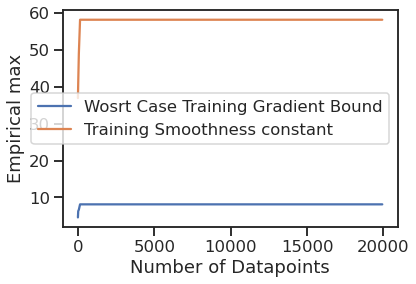

In [10]:
## New try for TMLR
plot_stability_e1(grad_list, hess_list, x_values, path='mnist.pdf')

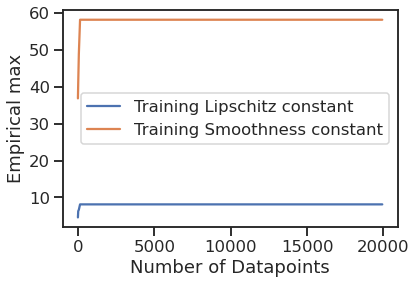

In [8]:
## Older plot for ICML submission
# plot_stability_e1(grad_list, hess_list, x_values, path='mnist.pdf')

## Main result exp1 FMNIST

In [11]:
root_dir = 'results/t2/'
path = 'try2f_t8_r.4'
lp_ylim = (-0.1, 13)
sm_ylim = (-0.1, 110)
details = get_exp_details(root_dir, path)
grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)
# plot_e1(grad_list, hess_list, x_values, path='Fmnist.pdf',lp_ylim= lp_ylim,sm_ylim= sm_ylim)

hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)


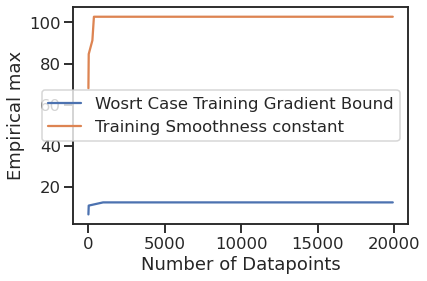

In [12]:
## New plot for TMLR
plot_stability_e1(grad_list, hess_list, x_values, path='Fmnist.pdf')

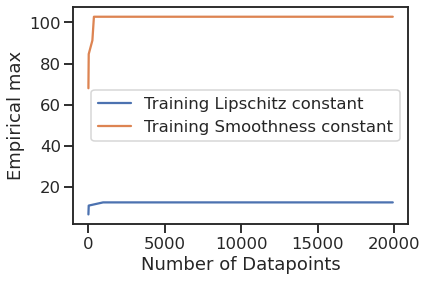

In [10]:
## Older plot for ICML
# plot_stability_e1(grad_list, hess_list, x_values, path='Fmnist.pdf')